# Reinforcement Q-learning with RNN as function approximation

- portfolio grid of size 10 (0 to 1)
- 2 hidden neural layers with the first one being the recurrent layer (also has the weights of the previous 3 states as input)
- Improved by Dropout 
- Transaction costs 

In [1]:
# initialization
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import real data
mdata = pd.read_csv('data_ext.csv') #Three stocks (R,X_s,X_b) Without predictors
mdata = np.array(mdata[['r','xs','xb','snom','spe','sspr']])

In [2]:
# import real data
mdata = pd.read_excel('sim_data_CER.xlsx') #Three stocks (R,X_s,X_b) Without predictors
mdata = np.array(mdata[['r','xs','xb']])

In [3]:
#hyperparameters
series_length = 15                                           
batch_size = 1                                              
truncated_backprop_length = series_length//batch_size       # How many previous stock returns to take as input for the model
state_size = 4                                              # Number of nodes in the first hidden layer
num_classes = 10                                            # Number of classes to predict (10 actions possible so 10 classes)
echo_step = 3                                               # How many previous states the neural network takes as input
num_stocks = 6                                              # Amount of stocks into consideration
gamma = 0.95                                                   # Discount factor of future Q-values
gammaUtil = 2
epsilon = 0.1                                               # For the randomization of actions
# n = mdata.size/7-4                                          # Length of the total data
n = 707
periods = 60                                                # How many periods in the future to predict
epochs = 5                                                  # Amount of iterations to train the Neural Network
TC = 0                                                      # Percentage of transaction costs
dropout_prob = (1 - 0.8)                                    # Percentage of neuron nodes to keep in the Network using dropout
qlearningrate = 0.1

# Initialization of the Tensorflow placeholders and the network

In [4]:
#Initialize Recurrent Neural Network and set-up the placeholders
tf.reset_default_graph()
NN_input = tf.placeholder(tf.float32, [num_stocks, batch_size, truncated_backprop_length])
init_state = tf.placeholder(tf.float32, [num_stocks, batch_size, state_size])
Q_Next = tf.placeholder(tf.float32, [truncated_backprop_length, batch_size, num_classes])

# Weights and biases
W = tf.Variable(np.random.rand(num_stocks, state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((num_stocks,1,state_size)), dtype=tf.float32)
W2 = tf.Variable(np.random.rand(num_stocks, state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((num_stocks, 1,num_classes)), dtype=tf.float32)

# Actually all transformations need their own weigths and biases!!
# Feature for later

inputs_series = tf.unstack(NN_input, axis=2)
labels_series = tf.unstack(Q_Next, axis=0)

#Forward pass
current_state = init_state
states_series = []

for current_input in inputs_series:
    current_input = tf.reshape(current_input, [num_stocks,batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state],axis=2)  # Increasing number of columns
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated,W) + b)  # Broadcasted addition
    dropout_state = tf.nn.dropout(next_state,dropout_prob)     # DROPOUT
    states_series.append(dropout_state)
    current_state = next_state

#calculate loss
Q_FA = [tf.nn.relu(tf.matmul(state, W2) + b2) for state in states_series]
# dropout_Q = tf.nn.dropout(Q_FA,dropout_prob)    # DROPOUT
# Q_FA = tf.reduce_sum(dropout_Q,axis=1)
Q_FA = tf.reduce_sum(Q_FA,axis=1)
A_Max = tf.argmax(Q_FA[-1],1) # only use the latest Q of the RNN for the determination of the optimal weights
Q_series = tf.unstack(Q_FA, axis=0)

# Calculate loss for the NN from the Q values
losses = [ abs(logits - labels) for logits, labels in zip(Q_series,labels_series)]
total_loss = tf.reduce_mean(losses)
# loss = tf.reduce_sum(tf.square(Q_Next - Q_FA))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
updateModel = trainer.minimize(total_loss)

#Define Action Matrix (Now discrete case) 
A = np.linspace(0,1,10) # portfolio weights of stocks (1-weight) is the weight in the bonds

# Training of the RNN function approximation

451


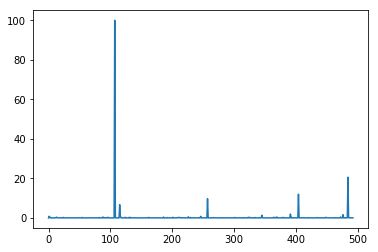

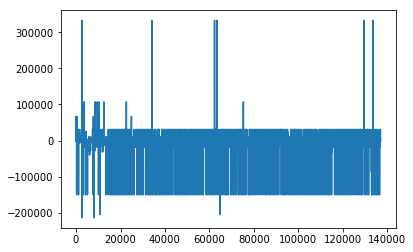

Writing away results
452


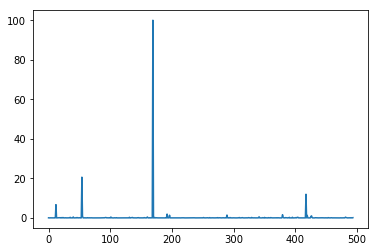

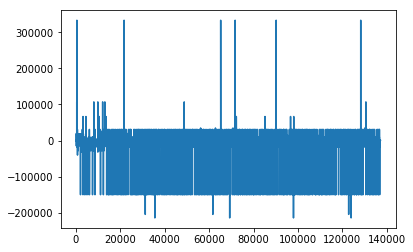

Writing away results
453


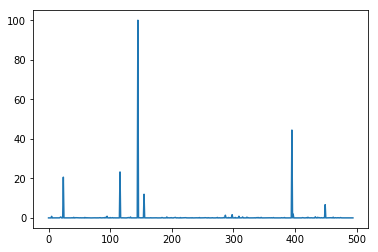

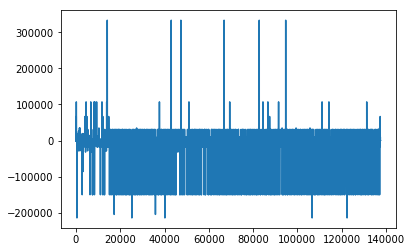

Writing away results
454


KeyboardInterrupt: 

In [5]:
### initialization for insight series
TWlist = []
Index = []
MWeights = []
Turnover = []
RU = []
AllWeights = []

with tf.Session() as sess:
    for i in range(451,497):
        OptimalWeights = np.zeros(periods-1)
        currentK = 0;
        print(i)
        sess.run(tf.global_variables_initializer()) # initialize the Neural Network again
        rlist = []
        end = 0
        
        while currentK < periods - 1:
            #Initilization
            NN_data = mdata[0:i+currentK]  # rolling window
            #initialize an empty hidden state
            _current_state = np.zeros((num_stocks, batch_size, state_size))
            # NN_data = mdata[0:i+currentK]   #Expanding window
            rAll = 0
            currentEpoch = 0
            
            while currentEpoch < epochs:
                a_old = 0
                epoch_loss = []
                
                # Randomizing of the data by the indexes
                indexes = np.asarray(range(0,len(NN_data)-truncated_backprop_length-1))
                end = len(NN_data)-truncated_backprop_length-1
                np.random.shuffle(indexes)
                
                #Training of the Q-Network for the data available (with Neural Nets) 
                for j in indexes:
                    s = NN_data[j:j+truncated_backprop_length,0:num_stocks].reshape(num_stocks,batch_size,truncated_backprop_length)
                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    a_int,allQ = sess.run([A_Max,Q_FA],feed_dict={NN_input:s, init_state:_current_state})
                    a = A[a_int-1]  # -1 because the output neurons are labeled 1 till 101 and it will be an index
                    if np.random.rand(1) < epsilon:
                        a = random.choice(A)

                    #Get new state and reward from environment
                    s1 = NN_data[j+truncated_backprop_length:j+truncated_backprop_length+1,1:4]
#                   s1 = mdata[i+currentK+j+truncated_backprop_length+1,1:4]
                    r = (a*s1[0][0] + (1-a)*s1[0][1] - TC*abs(a-a_old)) #reward: this is now the wealth gained from this step, but could be other rewards like utility
                    r = (1/1-gammaUtil)*pow(r,(1-gammaUtil))
                    rlist.append(r)
                    ## idea: ADD also exp(s1) to the transaction costs
                    a_old = a
                    s1 = NN_data[j+1:j+truncated_backprop_length+1,0:num_stocks].reshape(num_stocks,batch_size,truncated_backprop_length)
                    Q = sess.run(Q_FA,feed_dict={NN_input:s1, init_state:_current_state})
                    
                    #Obtain maxQ' and set our target value for chosen action.
                    Q1 = np.max(Q[-1])
                    targetQ = allQ
#                     targetQ[-1,0,int(a*9)] = r + gamma*Q1
                    targetQ[-1,0,int(a*9)] = targetQ[-1,0,int(a*9)] + qlearningrate*(r + gamma*Q1 - targetQ[-1,0,int(a*9)]) 
            
                    ### idea: Print the losses 
        
                    #Train the neural network using target and predicted Q values
                    s = s1
                    _,_current_state,W1,_total_loss = sess.run([updateModel,current_state,NN_input,total_loss],feed_dict={NN_input:s,Q_Next:targetQ, init_state:_current_state})
                    epoch_loss.append(_total_loss)
                currentEpoch += 1
#                 print(sum(epoch_loss))
                    
            # After training now calculate the optimal weights for the K=60 periods to come
            s1 = NN_data[end:end+truncated_backprop_length,0:num_stocks].reshape(num_stocks,batch_size,truncated_backprop_length)
            a_int,allQ = sess.run([A_Max,Q_FA],feed_dict={NN_input:s, init_state:_current_state})
            aOpt = A[a_int-1]
            OptimalWeights[currentK] = aOpt
            currentK += 1
        
        plt.ion()
        plt.plot(epoch_loss)
        plt.show()
        plt.plot(rlist)
        plt.show()
        
        firstdiff = OptimalWeights[1:] - OptimalWeights[:-1]
        # For insight purposes
        MWeights.append(np.mean(OptimalWeights))
#         x = mdata[i+currentK+j+truncated_backprop_length+1,1:4]
        x = mdata[end + truncated_backprop_length - currentK:end+truncated_backprop_length,1:4]
        TerminalWealth = np.exp(sum(OptimalWeights*x[:,0] + (1-OptimalWeights)*x[:,1]))
        TWlist.append(TerminalWealth)
        Index.append(i)
        # Turnover
        Turnover.append(sum(abs(firstdiff*np.exp(mdata[i+1:i+currentK,1])) + abs((1-firstdiff)*np.exp(mdata[i+1:i+currentK,2]))))
        # Realized Utility
        RU.append((1/(1-5))*pow(TerminalWealth,(1-5)))
        AllWeights.append(OptimalWeights)
        
        print('Writing away results')
        df = pd.DataFrame({'index date':Index,'TW':TWlist, 'Mean Weights Xs':MWeights,'Turnover':Turnover, 'Realized Utility':RU})
        df.to_excel('RNN_5e_Util.xlsx', sheet_name='sheet1', index=False)
        dfweights = pd.DataFrame({'Weights':AllWeights})
        dfweights.to_excel('AllWeights_RNN_e5_Util.xlsx')
        
    # close session
plt.plot(MWeights)
plt.plot(TWlist)